# Machine Learning - Analysis

---

In [1]:
import pandas as pd
import numpy as np

import re

from plotnine import *
import matplotlib.pyplot as plt
from matplotlib import gridspec

from IPython.display import display

pd.set_option('max_colwidth', None)

PATH = '../../thesis/'
WK_PATH = PATH + 'wiki/data/intros/'
HM_PATH = PATH + '100mentors/data/'

## 1. 100mentors dataset

---

In [2]:
hm = pd.read_csv(HM_PATH + 'dataset.v0.0.2-cleaned.csv')
hm.head(3)

,id,questionText,topicName,information.type,information.language,tagName,tagParentName,tagType
0,5c0669f6bddb186d31c80451,"How to answer: ""Reflect on an idea or experience that makes you excited about learning."" #StanfordUniversity",College & Career Counselling,TEXT,en,General Language and Literature,Language and Literature,general
1,5c0669f6bddb186d31c80451,"How to answer: ""Reflect on an idea or experience that makes you excited about learning."" #StanfordUniversity",College & Career Counselling,TEXT,en,General Foreign Languages,Foreign Languages,general
2,5c0669f6bddb186d31c80451,"How to answer: ""Reflect on an idea or experience that makes you excited about learning."" #StanfordUniversity",College & Career Counselling,TEXT,en,General Global Politics,Global Politics,general


In [3]:
hm = hm[['tagParentName', 'questionText']]
hm = hm.rename(columns={'tagParentName': 'tag', 'questionText': 'text'})
display(hm.head(3))
print(hm.shape)

,tag,text
0,Language and Literature,"How to answer: ""Reflect on an idea or experience that makes you excited about learning."" #StanfordUniversity"
1,Foreign Languages,"How to answer: ""Reflect on an idea or experience that makes you excited about learning."" #StanfordUniversity"
2,Global Politics,"How to answer: ""Reflect on an idea or experience that makes you excited about learning."" #StanfordUniversity"


(1847, 2)


In [4]:
print('duplicated:', hm.duplicated().sum())

duplicated: 676


In [5]:
hm.drop_duplicates(inplace=True)
hm.shape

(1171, 2)

In [6]:
print('number of questions with "Foreign Languages" tag:', (hm['tag'] == 'Foreign Languages').sum())

number of questions with "Foreign Languages" tag: 7


In [7]:
hm = hm[hm['tag'] != 'Foreign Languages']
hm.shape

(1164, 2)

In [8]:
hmf = hm.groupby(by='text')['tag'].apply(lambda tags: frozenset(tags)).reset_index(name='tags')
display(hmf.head(3))
print(hmf.shape)

,text,tags
0,"""85% of today's jobs won't exist in the future of work"". What will happen if we see this ""overnight"" due to the outbreak of the coronavirus?",(Economics)
1,140 years ago Karl Marx predicted that the capitalist system is inherently unstable. Do you agree with this?,(Economics)
2,"A lot of people ""detox""...Is it actually possible to detox our body?",(Biology)


(819, 2)


In [9]:
hmf['tags']\
    .apply(len)\
    .value_counts()\
    .reset_index()\
    .rename(columns={'index': 'tags_len', 'tags': 'count'})\
    .sort_values(by='tags_len')

,tags_len,count
0,1,659
1,2,125
2,3,16
5,4,2
3,8,10
6,9,2
4,20,4
7,21,1


In [10]:
hmf = hmf[hmf['tags'].apply(len) < 5]
hmf.shape

(802, 2)

In [11]:
hmf_gbt = hmf['tags']\
    .value_counts()\
    .reset_index()\
    .rename(columns={'index': 'tags', 'tags': 'count'})
hmf_gbt

,tags,count
0,(Business Management),218
1,(Career),118
2,(Economics),85
3,"(Economics, Business Management)",78
4,"(Sports, Exercise and Health Science)",54
5,(Physics),51
6,(Biology),45
7,(History),24
8,"(Language and Literature, Career)",14
9,(Global Politics),14


In [12]:
hmf_gbt['count']\
    .value_counts()\
    .reset_index()\
    .rename(columns={'index': 'tags_with_N_samples', 'size': 'count'})\
    .sort_values(by='tags_with_N_samples')

,tags_with_N_samples,count
0,1,6
1,2,3
2,3,2
3,4,2
4,5,2
5,6,2
6,7,2
7,9,2
17,10,1
13,11,1


In [13]:
hmf.explode('tags').rename(columns={'tags': 'tag'}).to_csv('./100mentors_finallized.csv', index=False)

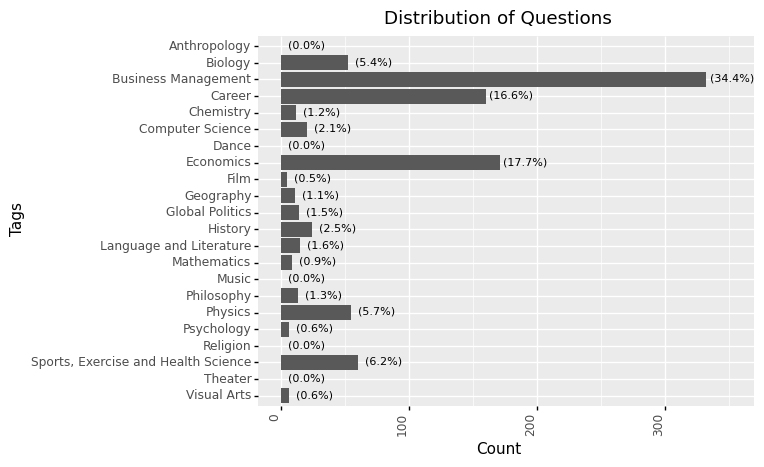

<ggplot: (357865460)>

In [14]:
hmf_stat = hmf.explode('tags')['tags'].value_counts().reset_index(name='count')
hmf_stat['perc'] = hmf_stat['count'] / hmf_stat['count'].sum()
hmf_stat = hmf_stat.append([
    { 'index': 'Anthropology', 'count': 0, 'perc': .0}, 
    { 'index': 'Dance', 'count': 0, 'perc': .0 },
    { 'index': 'Music', 'count': 0, 'perc': .0 },
    { 'index': 'Religion', 'count': 0, 'perc': .0 },
    { 'index': 'Theater', 'count': 0, 'perc': .0 },
], ignore_index=True)

ggplot(data=hmf_stat) +\
    geom_bar(aes(x='index', y='count'), stat='identity') +\
    geom_text(
        aes(x='index', y='count', label='perc*100'),
        stat='identity',
        nudge_x=-0.25,
        nudge_y=20,
        va='bottom',
        size=8,
        format_string='({:.1f}%)'
    ) +\
    scale_x_discrete(limits=hmf_stat['index'].sort_values()[::-1]) +\
    coord_flip() +\
    labs(title='Distribution of Questions', x='Tags', y='Count') +\
    theme(axis_text_x=element_text(rotation=90, hjust=1))

## 2. Wikipedia dataset

---

In [15]:
wk = pd.read_csv(WK_PATH + 'dataset.v1.0.3-cleaned.csv')
display(wk.head(3))
print(wk.shape)

,tag,title,text
0,Visual Arts,Art,"Art is a diverse range of (and products of) human activities involving creative imagination to express technical proficiency, beauty, emotional power, or conceptual ideas.[1][2][3] There is no generally agreed definition of what constitutes art,[4][5][6] and ideas have changed over time. The three classical branches of visual art are painting, sculpture, and architecture.[7] Theatre, dance, and other performing arts, as well as literature, music, film and other media such as interactive media, are included in a broader definition of the arts.[1][8] Until the 17th century, art referred to any skill or mastery and was not differentiated from crafts or sciences. In modern usage after the 17th century, where aesthetic considerations are paramount, the fine arts are separated and distinguished from acquired skills in general, such as the decorative or applied arts. The nature of art and related concepts, such as creativity and interpretation, are explored in a branch of philosophy known as aesthetics.[9] The resulting artworks are studied in the professional fields of art criticism and the history of art."
1,Visual Arts,Painting,"Painting is the practice of applying paint, pigment, color or other medium to a solid surface (called the ""matrix"" or ""support"").[1] The medium is commonly applied to the base with a brush, but other implements, such as knives, sponges, and airbrushes, can be used. In art, the term painting describes both the act and the result of the action (the final work is called ""a painting""). The support for paintings includes such surfaces as walls, paper, canvas, wood, glass, lacquer, pottery, leaf, copper and concrete, and the painting may incorporate multiple other materials, including sand, clay, paper, plaster, gold leaf, and even whole objects. Painting is an important form in the visual arts, bringing in elements such as drawing, composition, gesture (as in gestural painting), narration (as in narrative art), and abstraction (as in abstract art).[2] Paintings can be naturalistic and representational (as in still life and landscape painting), photographic, abstract, narrative, symbolistic (as in Symbolist art), emotive (as in Expressionism) or political in nature (as in Artivism). A portion of the history of painting in both Eastern and Western art is dominated by religious art. Examples of this kind of painting range from artwork depicting mythological figures on pottery, to Biblical scenes on the Sistine Chapel ceiling, to scenes from the life of Buddha (or other images of Eastern religious origin)."
2,Visual Arts,Drawing,"Drawing is a form of visual art in which an artist uses instruments to mark paper or other two-dimensional surface. Drawing instruments include graphite pencils, pen and ink, various kinds of paints, inked brushes, colored pencils, crayons, charcoal, chalk, pastels, erasers, markers, styluses, and metals (such as silverpoint). Digital drawing is the act of using a computer to draw. Common methods of digital drawing include a stylus or finger on a touchscreen device, stylus- or finger-to-touchpad, or in some cases, a mouse. There are many digital art programs and devices. A drawing instrument releases a small amount of material onto a surface, leaving a visible mark. The most common support for drawing is paper, although other materials, such as cardboard, wood, plastic, leather, canvas, and board, have been used. Temporary drawings may be made on a blackboard or whiteboard. Drawing has been a popular and fundamental means of public expression throughout human history. It is one of the simplest and most efficient means of communicating ideas.[1] The wide availability of drawing instruments makes drawing one of the most common artistic activities. In addition to its more artistic forms, drawing is frequently used in commercial illustration, animation, architecture, engineering, and technical drawing. A quick, freehand drawing, usually not intended as 

(12870, 3)


In [16]:
wk = wk[['tag', 'text']]
display(wk.head(1))
print(wk.shape)

,tag,text
0,Visual Arts,"Art is a diverse range of (and products of) human activities involving creative imagination to express technical proficiency, beauty, emotional power, or conceptual ideas.[1][2][3] There is no generally agreed definition of what constitutes art,[4][5][6] and ideas have changed over time. The three classical branches of visual art are painting, sculpture, and architecture.[7] Theatre, dance, and other performing arts, as well as literature, music, film and other media such as interactive media, are included in a broader definition of the arts.[1][8] Until the 17th century, art referred to any skill or mastery and was not differentiated from crafts or sciences. In modern usage after the 17th century, where aesthetic considerations are paramount, the fine arts are separated and distinguished from acquired skills in general, such as the decorative or applied arts. The nature of art and related concepts, such as creativity and interpretation, are explored in a branch of philosophy known as aesthetics.[9] The resulting artworks are studied in the professional fields of art criticism and the history of art."


(12870, 2)


In [17]:
wkf = wk.groupby(by=['text'])['tag'].apply(lambda tags: frozenset(tags)).reset_index(name='tags')
display(wkf.head(1))
print(wkf.shape)

,text,tags
0,"Genetic engineering, also called genetic modification or genetic manipulation, is the direct manipulation of an organism's genes using biotechnology. It is a set of technologies used to change the genetic makeup of cells, including the transfer of genes within and across species boundaries to produce improved or novel organisms. New DNA is obtained by either isolating and copying the genetic material of interest using recombinant DNA methods or by artificially synthesising the DNA. A construct is usually created and used to insert this DNA into the host organism. The first recombinant DNA molecule was made by Paul Berg in 1972 by combining DNA from the monkey virus SV40 with the lambda virus. As well as inserting genes, the process can be used to remove, or ""knock out"", genes. The new DNA can be inserted randomly, or targeted to a specific part of the genome.[1] An organism that is generated through genetic engineering is considered to be genetically modified (GM) and the resulting entity is a genetically modified organism (GMO). The first GMO was a bacterium generated by Herbert Boyer and Stanley Cohen in 1973. Rudolf Jaenisch created the first GM animal when he inserted foreign DNA into a mouse in 1974. The first company to focus on genetic engineering, Genentech, was founded in 1976 and started the production of human proteins. Genetically engineered human insulin was produced in 1978 and insulin-producing bacteria were commercialised in 1982. Genetically modified food has been sold since 1994, with the release of the Flavr Savr tomato. The Flavr Savr was engineered to have a longer shelf life, but most current GM crops are modified to increase resistance to insects and herbicides. GloFish, the first GMO designed as a pet, was sold in the United States in December 2003. In 2016 salmon modified with a growth hormone were sold. Genetic engineering has been applied in numerous fields including research, medicine, industrial biotechnology and agriculture. In research GMOs are used to study gene function and expression through loss of function, gain of function, tracking and expression experiments. By knocking out genes responsible for certain conditions it is possible to create animal model organisms of human diseases. As well as producing hormones, vaccines and other drugs, genetic engineering has the potential to cure genetic diseases through gene therapy. The same techniques that are used to produce drugs can also have industrial applications such as producing enzymes for laundry detergent, cheeses and other products. The rise of commercialised genetically modified crops has provided economic benefit to farmers in many different countries, but has also been the source of most of the controversy surrounding the technology. This has been present since its early use; the first field trials were destroyed by anti-GM activists. Although there is a scientific consensus that currently available food derived from GM crops poses no greater risk to human health than conventional food, GM food safety is a leading concern with critics. Gene flow, impact on non-target organisms, control of the food supply and intellectual property rights have also been raised as potential issues. These concerns have led to the development of a regulatory framework, which started in 1975. It has led to an international treaty, the Cartagena Protocol on Biosafety, that was adopted in 2000. Individual countries have developed their own regulatory systems regarding GMOs, with the most marked differences occurring between the US and Europe.","(Biology, History, Philosophy)"


(8722, 2)


In [18]:
wkf['tags']\
    .apply(len)\
    .value_counts()\
    .reset_index()\
    .rename(columns={'index': 'tags_len', 'tags': 'count'})\
    .sort_values(by='tags_len')

,tags_len,count
0,1,6935
1,2,1229
2,3,335
3,4,104
4,5,45
5,6,25
6,7,17
8,8,8
7,9,9
9,10,6


In [19]:
wkf = wkf[wkf['tags'].apply(len) < 5] # maybe NOT
wkf.shape

(8603, 2)

In [20]:
wkf_gbt = wkf.groupby(by='tags', as_index=False).size().rename(columns={'size': 'count'})
wkf_gbt.head(3)

,tags,count
0,"(Biology, History, Philosophy)",1
1,"(Dance, Language and Literature, Religion)",1
2,"(Dance, Visual Arts, Language and Literature)",1


In [21]:
wkf_gbt['count']\
    .value_counts()\
    .reset_index()\
    .rename(columns={'index': 'tags_with_N_samples', 'size': 'count'})\
    .sort_values(by='tags_with_N_samples')

,tags_with_N_samples,count
0,1,219
1,2,59
2,3,29
4,4,9
3,5,12
5,6,6
19,7,2
6,8,5
8,9,4
7,10,5


In [22]:
wkf_gbt = wkf_gbt[wkf_gbt['count'] > 5]
print(wkf_gbt.shape)

(76, 2)


In [23]:
wkf = wkf[wkf['tags'].isin(wkf_gbt['tags'])]
wkf.shape

(8083, 2)

In [24]:
wkf.explode('tags').rename(columns={'tags': 'tag'}).to_csv('./wikipedia_finallized.csv', index=False)

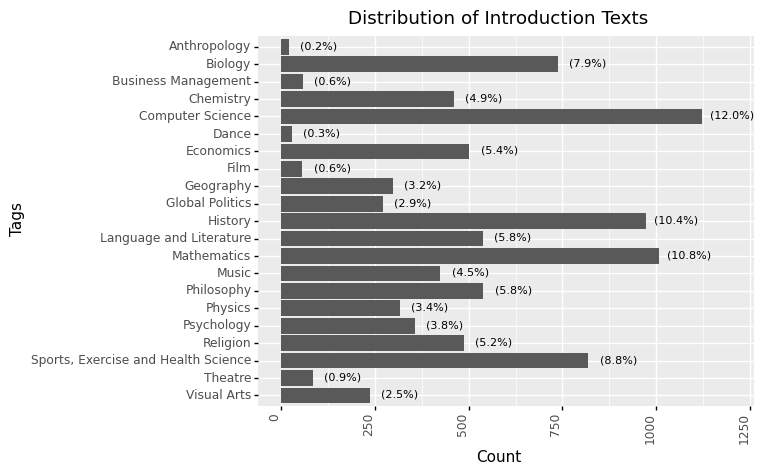

<ggplot: (358165839)>

In [25]:
wkf_stat = wkf.explode('tags')['tags'].value_counts().reset_index(name='count')
wkf_stat['perc'] = wkf_stat['count'] / wkf_stat['count'].sum()

ggplot(data=wkf_stat) +\
    geom_bar(aes(x='index', y='count'), stat='identity') +\
    geom_text(
        aes(x='index', y='count', label='perc*100'),
        stat='identity',
        nudge_x=-0.25,
        nudge_y=80,
        va='bottom',
        color='black',
        size=8,
        format_string='({:.1f}%)'
    ) +\
    scale_x_discrete(limits=wkf_stat['index'].sort_values()[::-1]) +\
    coord_flip() +\
    labs(title='Distribution of Introduction Texts', x='Tags', y='Count') +\
    theme(axis_text_x=element_text(rotation=90, hjust=1))

## Dataset Metrics & Statistics

---

### Dataset Metrics

---

### 100mentors

In [26]:
lcard_hm = hmf['tags'].apply(lambda tags: len(tags)).mean()
ldiver_hm = len(hmf['tags'].apply(lambda tags: frozenset(tags)).unique())

print('Label Cardinality:', f'{lcard_hm:.2f}')
print('Label Diversity:', ldiver_hm)
print('Label Balanced Diversity:', f'{ldiver_hm / hmf.shape[0]:.4f}')

Label Cardinality: 1.20
Label Diversity: 33
Label Balanced Diversity: 0.0411


In [27]:
hmf_vc = hmf['tags']\
    .apply(lambda tags: len(tags))\
    .value_counts()\
    .reset_index()\
    .rename(columns={'index': 'Relevant Labels', 'tags': 'Count'})
hmf_vc

,Relevant Labels,Count
0,1,659
1,2,125
2,3,16
3,4,2


In [28]:
hmf['tags']\
    .apply(lambda tags: ', '.join(sorted(list(tags))))\
    .value_counts()\
    .reset_index()\
    .rename(columns={'index': 'Tags', 'tags': 'Count'})\
    .sort_values(by='Tags')

,Tags,Count
6,Biology,45
27,"Biology, Career",1
31,"Biology, Chemistry, Mathematics, Physics",1
25,"Biology, Chemistry, Physics",2
23,"Biology, Sports, Exercise and Health Science",3
0,Business Management,218
10,"Business Management, Career",11
17,"Business Management, Career, Computer Science",6
30,"Business Management, Career, Computer Science, Economics",1
19,"Business Management, Career, Economics",5


In [29]:
lcard_wk = wkf['tags'].apply(lambda tags: len(tags)).mean()
ldiver_wk = len(wkf['tags'].apply(lambda tags: frozenset(tags)).unique())

print('Label Cardinality:', f'{lcard_wk:.2f}')
print('Label Diversity:', ldiver_wk)
print('Label Balanced Diversity:', f'{ldiver_wk/wkf.shape[0]:.4f}')

Label Cardinality: 1.16
Label Diversity: 76
Label Balanced Diversity: 0.0094


In [30]:
wkf_vc = wkf['tags']\
    .apply(lambda tags: len(tags))\
    .value_counts()\
    .reset_index()\
    .rename(columns={'index': 'Relevant Labels', 'tags': 'Count'})
wkf_vc

,Relevant Labels,Count
0,1,6935
1,2,1043
2,3,105


In [31]:
wkf['tags']\
    .apply(lambda tags: ', '.join(sorted(list(tags))))\
    .value_counts()\
    .reset_index()\
    .rename(columns={'index': 'Tags', 'tags': 'Count'})\
    .sort_values(by='Tags')

,Tags,Count
36,Anthropology,21
4,Biology,511
23,"Biology, Chemistry",40
45,"Biology, Chemistry, Sports, Exercise and Health Science",16
60,"Biology, Computer Science",9
...,...,...
24,"Psychology, Sports, Exercise and Health Science",34
6,Religion,406
3,"Sports, Exercise and Health Science",606
18,Theatre,79


## Labels

---

In [32]:
import itertools

HM_CLASSES = {*itertools.chain.from_iterable(hmf['tags'])}
WK_CLASSES = {*itertools.chain.from_iterable(wkf['tags'])}

CLASSES = set(sorted(HM_CLASSES | WK_CLASSES))
NOT_HM_CLASSES = set(sorted(HM_CLASSES ^ CLASSES))
NOT_WK_CLASSES = set(sorted(WK_CLASSES ^ CLASSES))

print('*** All Classes ***')
print()
print('\n'.join(CLASSES))
print()
print('length:', len(CLASSES))

*** All Classes ***

Economics
Mathematics
Sports, Exercise and Health Science
Chemistry
Theatre
Music
Psychology
History
Language and Literature
Global Politics
Biology
Philosophy
Geography
Computer Science
Visual Arts
Dance
Career
Religion
Business Management
Anthropology
Film
Physics

length: 22


In [33]:
print('*** 100mentors Classes ***')
print()
print('\n'.join(sorted(HM_CLASSES)))

*** 100mentors Classes ***

Biology
Business Management
Career
Chemistry
Computer Science
Economics
Film
Geography
Global Politics
History
Language and Literature
Mathematics
Philosophy
Physics
Psychology
Sports, Exercise and Health Science
Visual Arts


In [34]:
print('*** NOT in 100mentors Classes ***')
print()
print('\n'.join(sorted(NOT_HM_CLASSES)))

*** NOT in 100mentors Classes ***

Anthropology
Dance
Music
Religion
Theatre


In [35]:
print('*** Wikipedia Classes')
print()
print('\n'.join(sorted(WK_CLASSES)))

*** Wikipedia Classes

Anthropology
Biology
Business Management
Chemistry
Computer Science
Dance
Economics
Film
Geography
Global Politics
History
Language and Literature
Mathematics
Music
Philosophy
Physics
Psychology
Religion
Sports, Exercise and Health Science
Theatre
Visual Arts


In [36]:
print('*** NOT in Wikipedia Classes ***')
print()
print('\n'.join(sorted(NOT_WK_CLASSES)))

*** NOT in Wikipedia Classes ***

Career


## Preprocessing

---

In [37]:
import nltk

nltk.download('popular')
nltk.download('tagsets')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /Users/pvarouktsis/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /Users/pvarouktsis/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /Users/pvarouktsis/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /Users/pvarouktsis/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /Users/pvarouktsis/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /Users/pvarouktsis/nltk_data...
[nltk_data]    |   Pa

True

In [38]:
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

In [39]:
from nltk import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

STOPWORDS = set(stopwords.words('english'))
wnl = WordNetLemmatizer()

# https://wordnet.princeton.edu/documentation/wndb5wn
def get_wn_pos(tag):
    if tag.startswith('NN'):
        return 'n' # noun
    elif tag.startswith('VB'):
        return 'v' # verb
    elif tag.startswith('JJ'):
        return 'a' # adjective
    elif tag.startswith('RB'):
        return 'r' # adverb
    else:
        return 'n' # noun => default of lemmatize()

def validate(token):
    if len(token) > 1\
        and token.isalpha()\
        and token not in STOPWORDS:
        return True
    return False

def preprocess(text):
    text = text.encode('ascii', 'ignore').decode('utf-8') # remove non-english chars
    text = re.sub(r'#[A-Za-z0-9_]+', '', text)            # remove hashtags
    text = text.lower()
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)
    
    lemmatized = []
    for token, tag in tagged:
        if not validate(token):
            continue

        wn_tag = get_wn_pos(tag)
        lemmatized.append( wnl.lemmatize(token, wn_tag) )
    
    text = ' '.join(token for token in lemmatized)

    return text

## Word Frequency

---

In [40]:
from nltk.probability import FreqDist

def word_freq(text):
    preprocessed = preprocess(text)

    fd = nltk.probability.FreqDist(wt for wt in word_tokenize(preprocessed))

    return dict(fd)

### 100mentors

In [41]:
hmf_exp = hmf.explode('tags').rename(columns={'tags': 'tag'})
display(hmf_exp.head(1))
print(hmf_exp.shape)

,text,tag
0,"""85% of today's jobs won't exist in the future of work"". What will happen if we see this ""overnight"" due to the outbreak of the coronavirus?",Economics


(965, 2)


In [42]:
hmf_unitext = hmf_exp.groupby(by='tag', as_index=False)['text'].apply(lambda text: ' '.join(text))
print(hmf_unitext.shape)

(17, 2)


In [43]:
hmf_wf = hmf_unitext\
    .groupby(by='tag')['text']\
    .apply(lambda text: 
           dict(
               sorted(
                   word_freq(str(text)).items(),
                   key=lambda item: item[-1],
                   reverse=True)[:30]
           )
          )\
    .dropna()\
    .reset_index()\
    .rename(columns={'level_1': 'word', 'text': 'count'})\
    .astype(dtype={'count': 'int32'})

hmf_wf.shape

(496, 3)

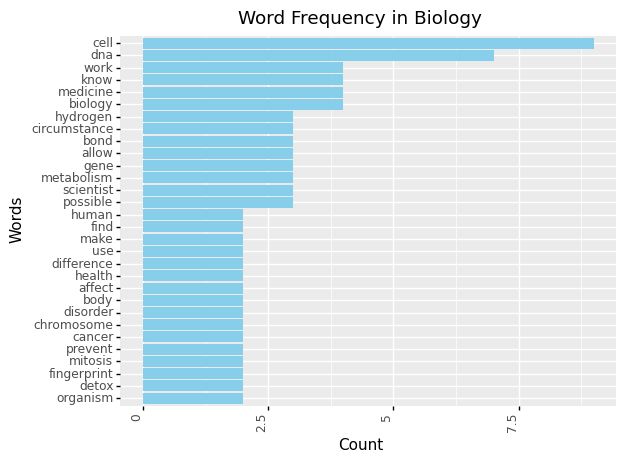

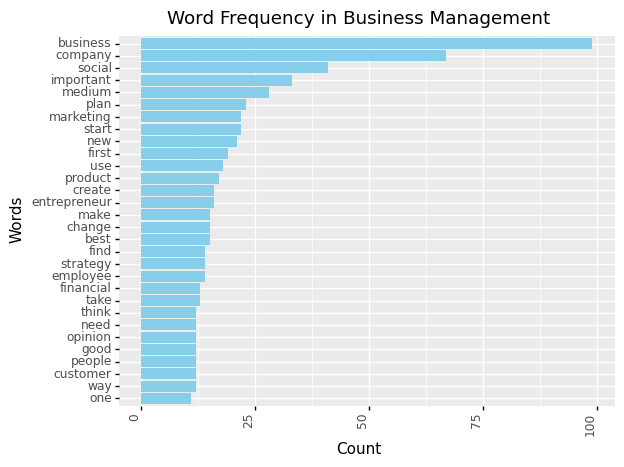

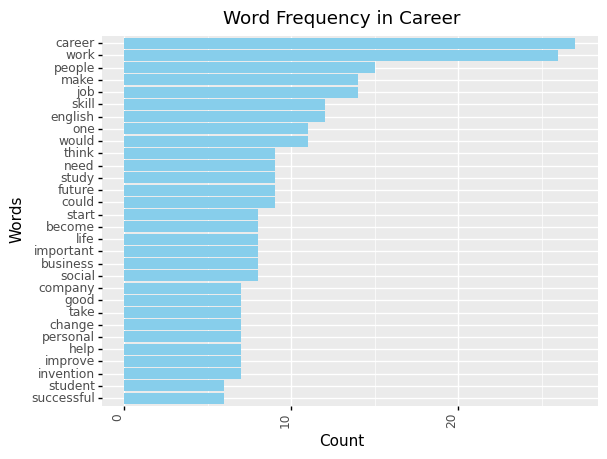

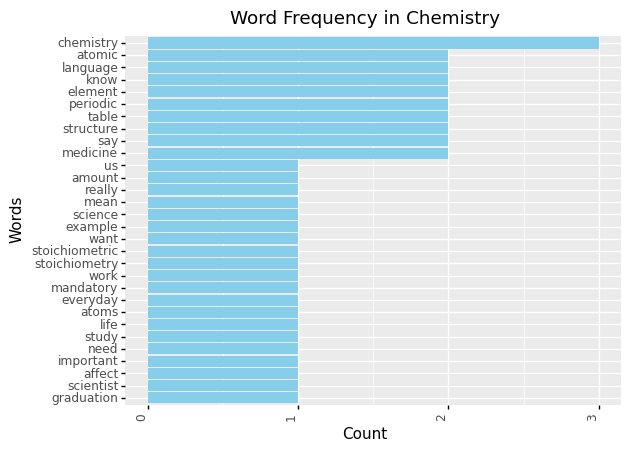

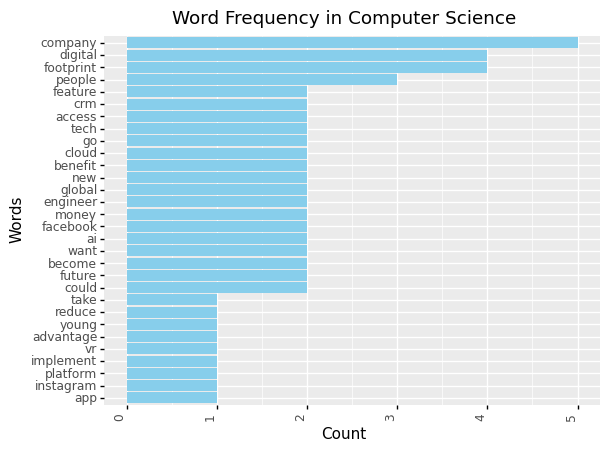

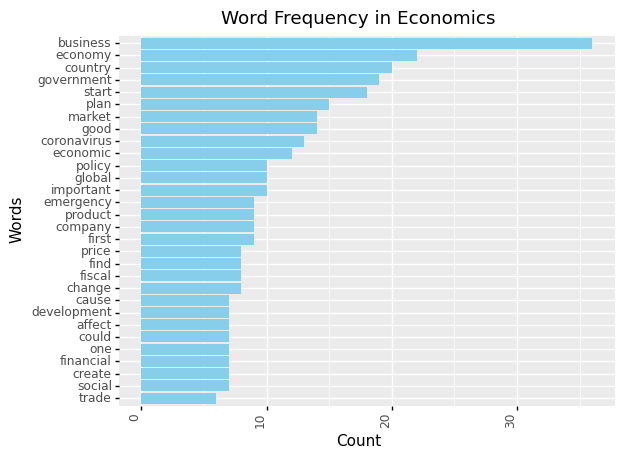

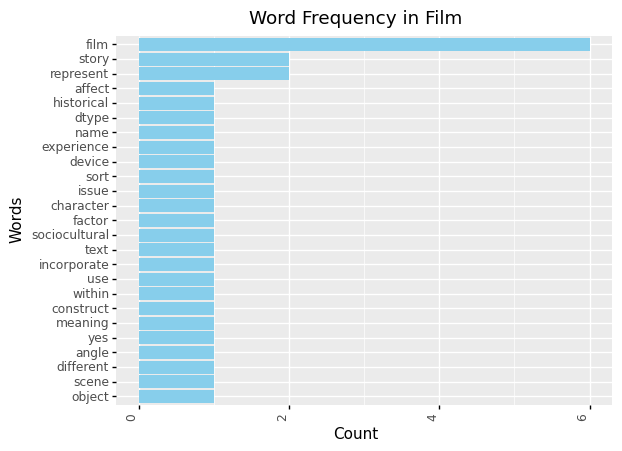

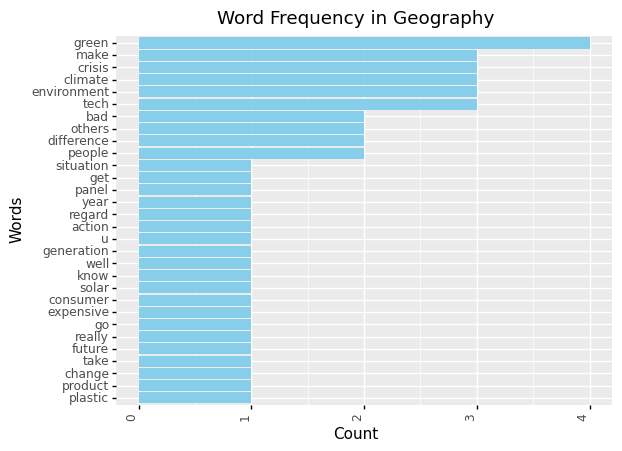

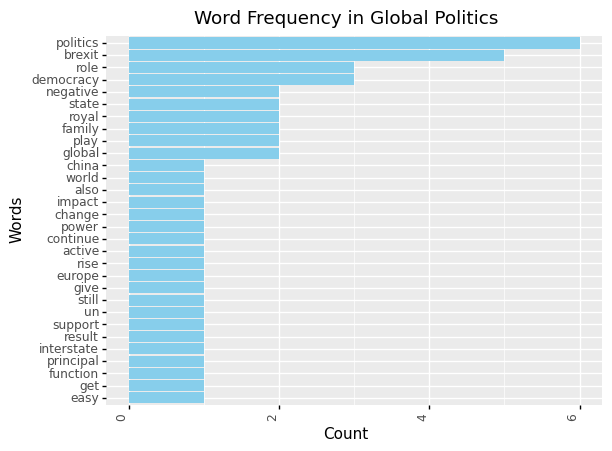

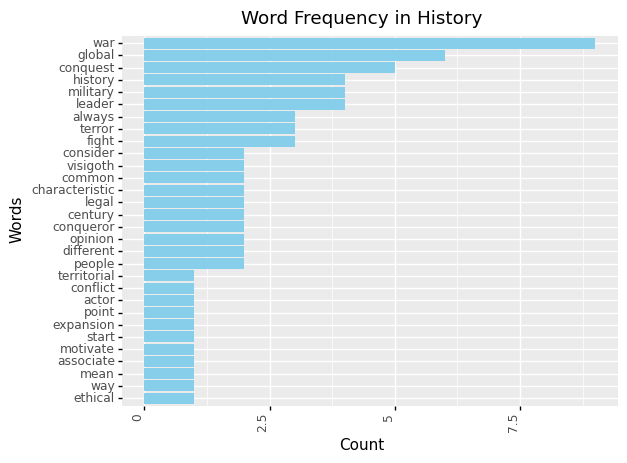

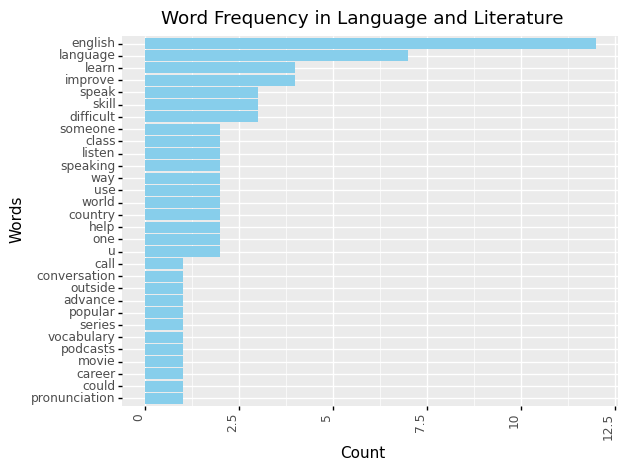

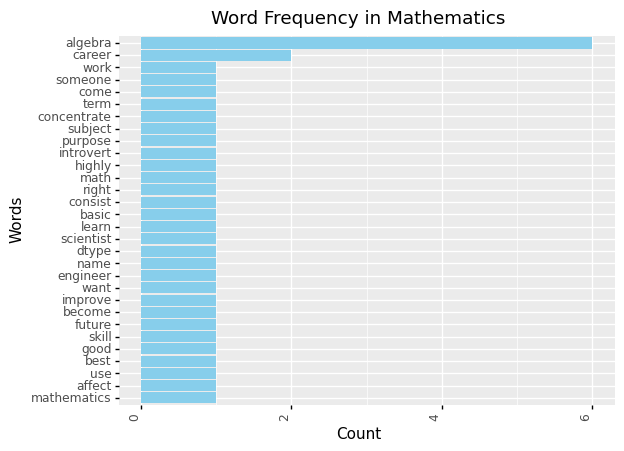

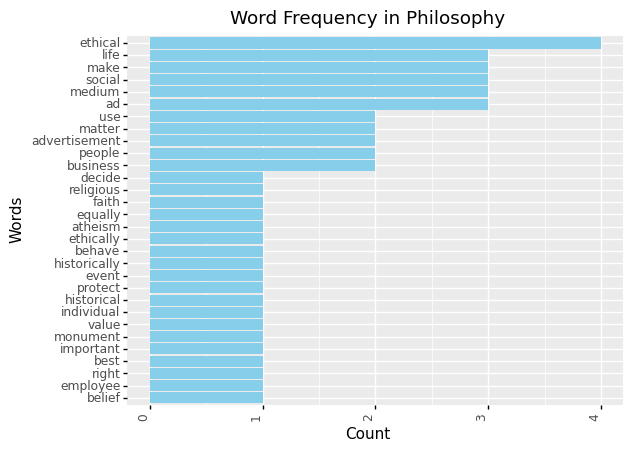

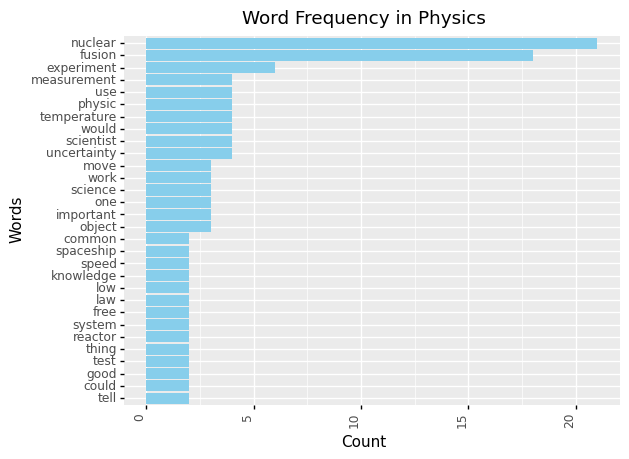

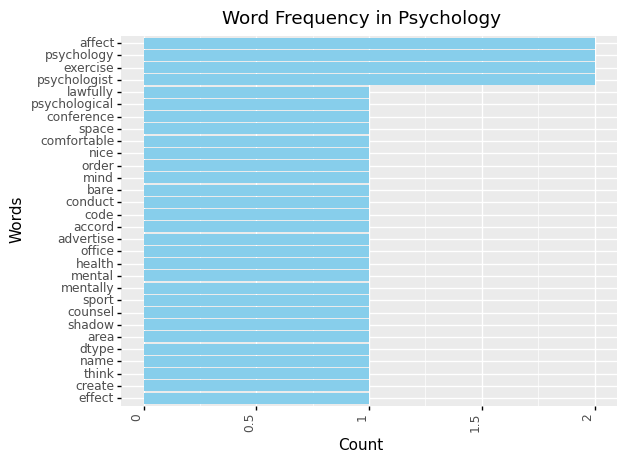

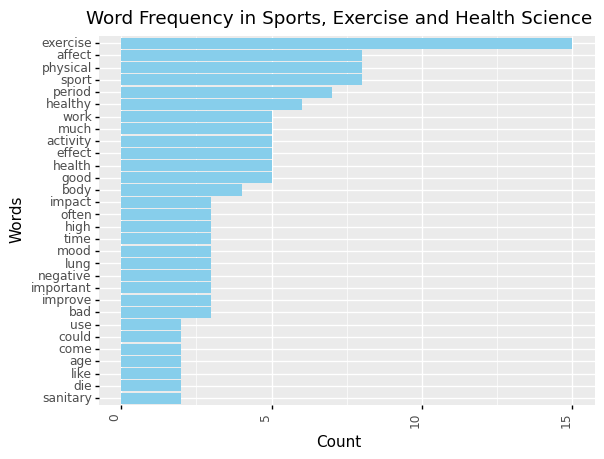

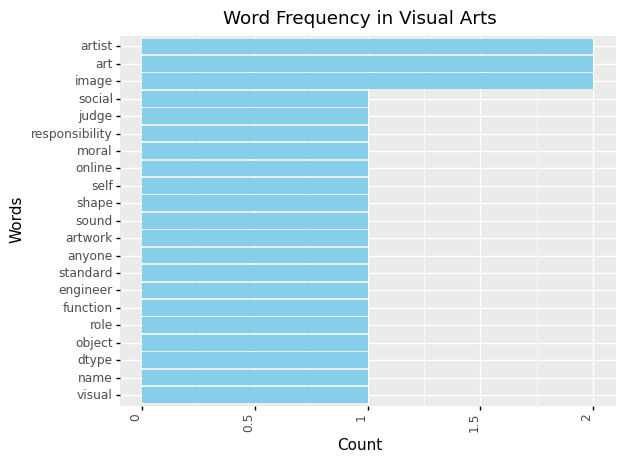

In [44]:
for tag in hmf_wf['tag'].unique():
    tdf = hmf_wf[hmf_wf['tag'] == tag].sort_values(by='count', ascending=False)
    g = ggplot(data=tdf) +\
            geom_bar(aes(x='word', y='count'), stat='identity', fill='skyblue') +\
            scale_x_discrete(limits=tdf['word'][::-1]) +\
            coord_flip() +\
            labs(title=f'Word Frequency in {tag}', x='Words', y='Count') +\
            theme(axis_text_x=element_text(rotation=90, hjust=1))

    print(g)

### Wikipedia

In [45]:
wkf_exp = wkf.explode('tags').rename(columns={'tags': 'tag'})
display(wkf_exp.head(1))
print(wkf_exp.shape)

,text,tag
1,"Jim Crow laws were state and local laws that enforced racial segregation in the Southern United States and elsewhere within the United States.[1][2] These laws were enacted in the late 19th and early 20th centuries by white Southern Democrat-dominated state legislatures to disenfranchise and remove political and economic gains made by black people during the Reconstruction period.[3] Jim Crow laws were enforced until 1965.[4] In practice, Jim Crow laws mandated racial segregation in all public facilities in the states of the former Confederate States of America and in some others, beginning in the 1870s. Jim Crow laws were upheld in 1896 in the case of Plessy vs. Ferguson, in which the U.S. Supreme Court laid out its ""separate but equal"" legal doctrine for facilities for African Americans. Moreover, public education had essentially been segregated since its establishment in most of the South after the Civil War in 1861–65. The legal principle of ""separate but equal"" racial segregation was extended to public facilities and transportation, including the coaches of interstate trains and buses. Facilities for African Americans were consistently inferior and underfunded compared to facilities for white Americans; sometimes, there were no facilities for the black community at all.[5][6] As a body of law, Jim Crow institutionalized economic, educational, and social disadvantages for many African Americans living in the United States.[5][6][7] Jim Crow laws and Jim Crow state constitutional provisions mandated the segregation of public schools, public places, and public transportation, and the segregation of restrooms, restaurants, and drinking fountains between white and black people. The U.S. military was already segregated. President Woodrow Wilson initiated the segregation of federal workplaces in 1913.[8] In 1954, segregation of public schools (state-sponsored) was declared unconstitutional by the U.S. Supreme Court under Chief Justice Earl Warren in the landmark case Brown v. Board of Education.[9][10][11] In some states, it took many years to implement this decision, while the Warren Court continued to rule against the Jim Crow laws in other cases such as Heart of Atlanta Motel, Inc. v. United States (1964).[12] Generally, the remaining Jim Crow laws were overruled by the Civil Rights Act of 1964 and the Voting Rights Act of 1965.",History


(9336, 2)


In [46]:
wkf_unitext = wkf_exp.groupby(by='tag', as_index=False)['text'].apply(lambda text: ' '.join(text))
print(wkf_unitext.shape)

(21, 2)


In [47]:
wkf_wf = wkf_unitext\
    .groupby(by='tag')['text']\
    .apply(lambda text: 
           dict(
               sorted(
                   word_freq(str(text.values)).items(),
                   key=lambda item: item[-1],
                   reverse=True)[:30]
           )
          )\
    .dropna()\
    .reset_index()\
    .rename(columns={'level_1': 'word', 'text': 'count'})\
    .astype(dtype={'count': 'int32'})

wkf_wf.shape

(630, 3)

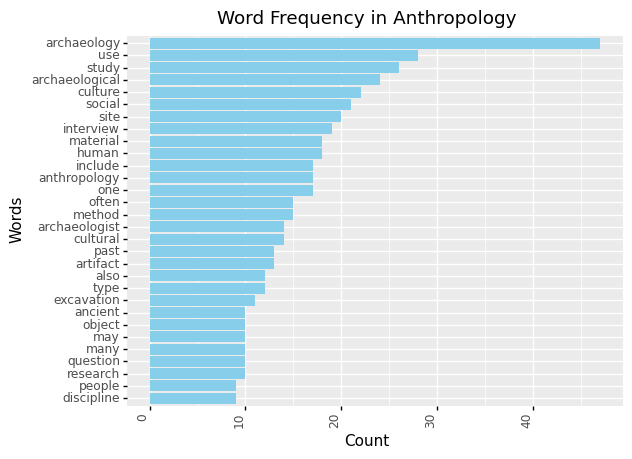

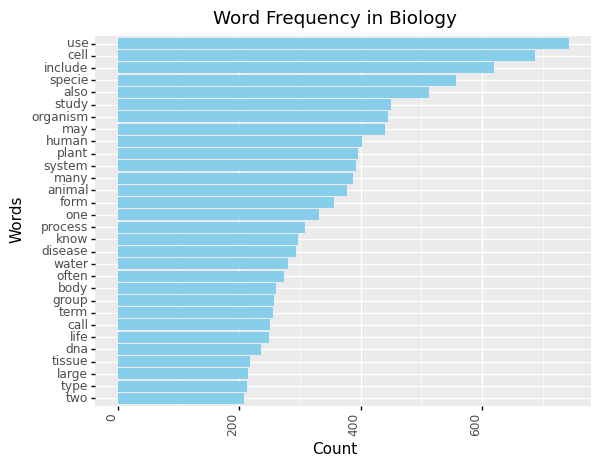

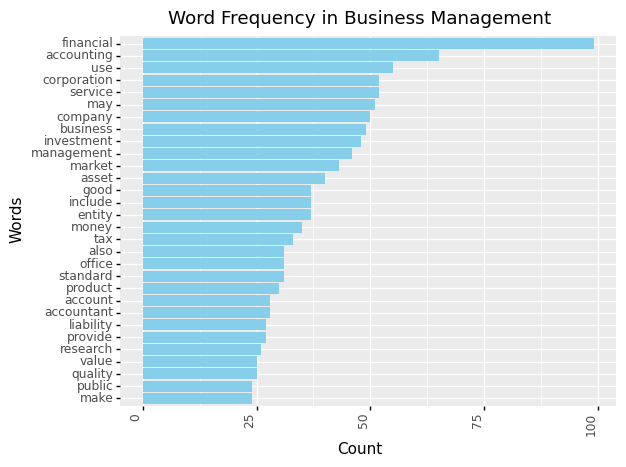

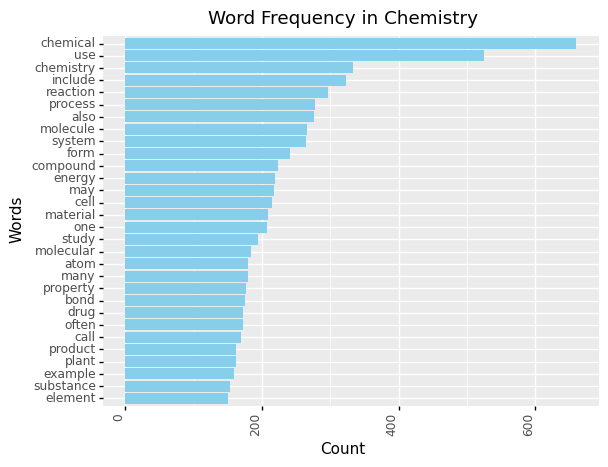

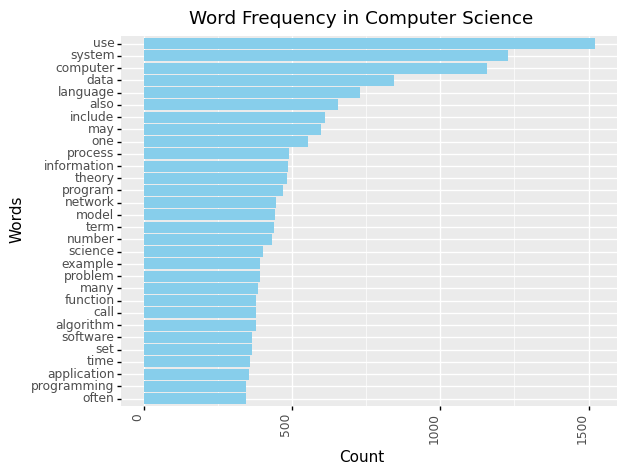

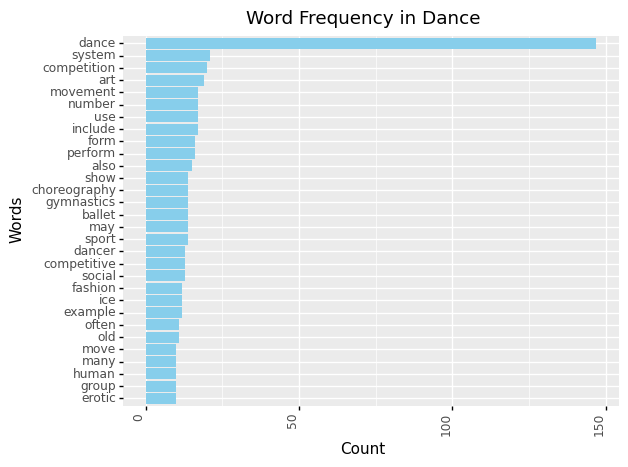

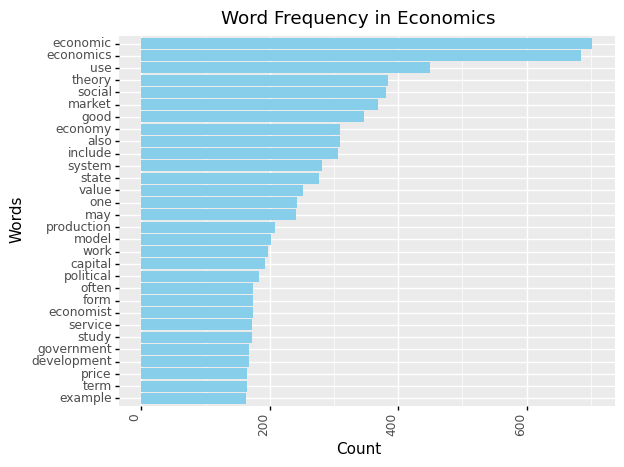

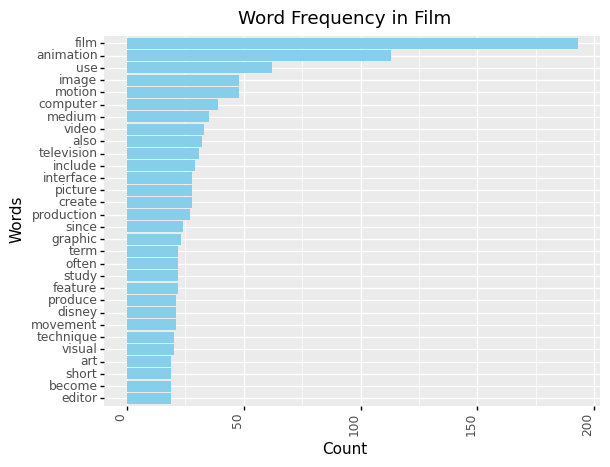

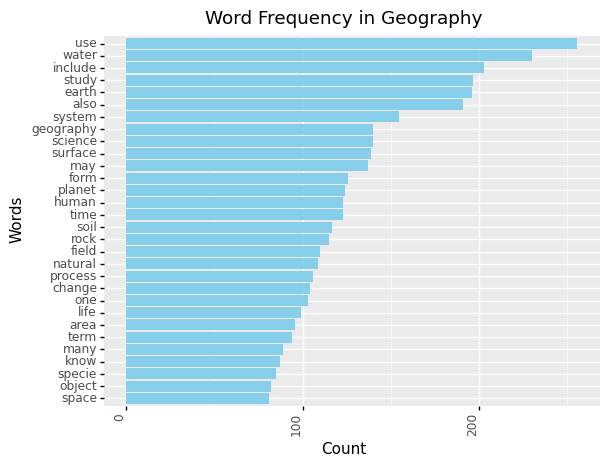

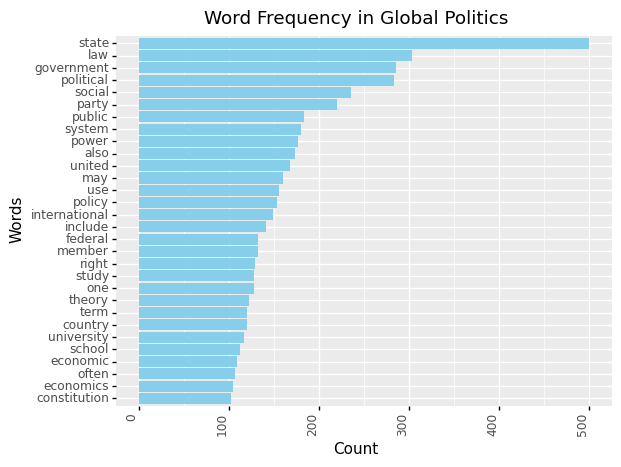

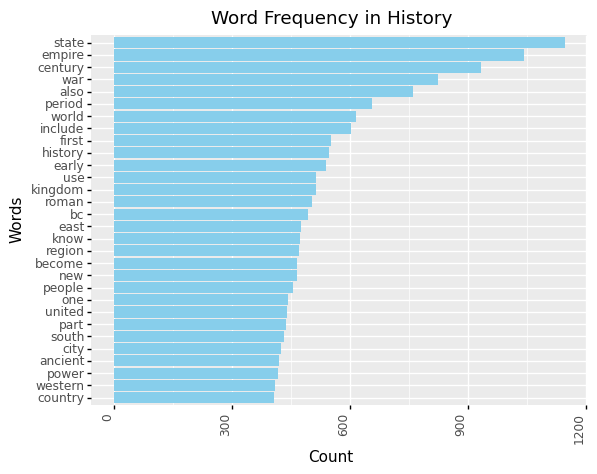

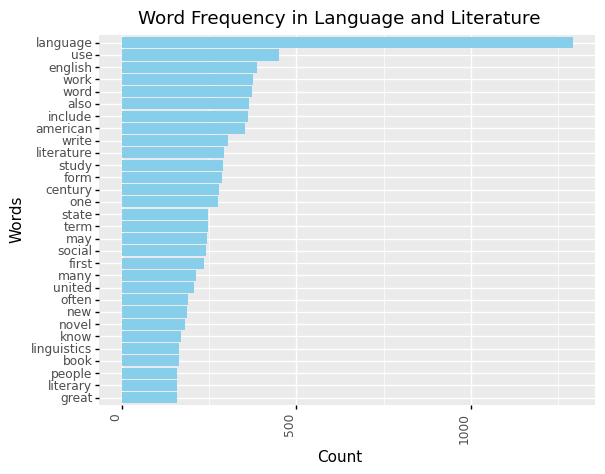

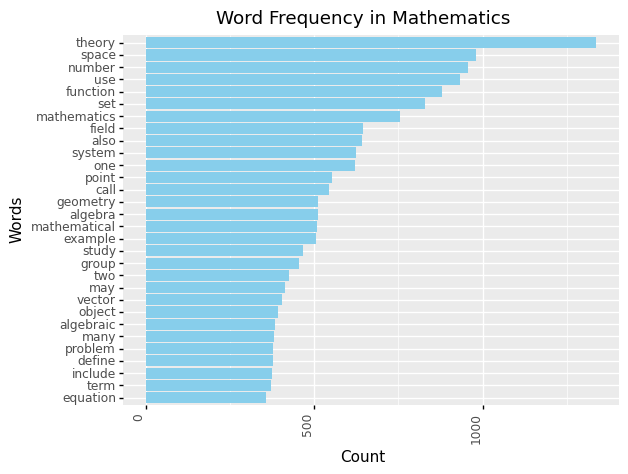

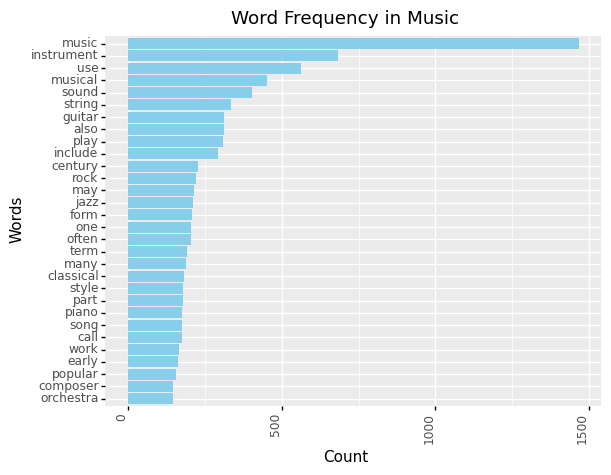

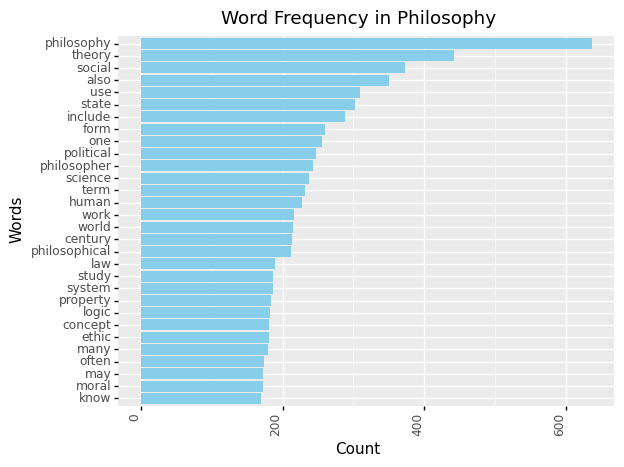

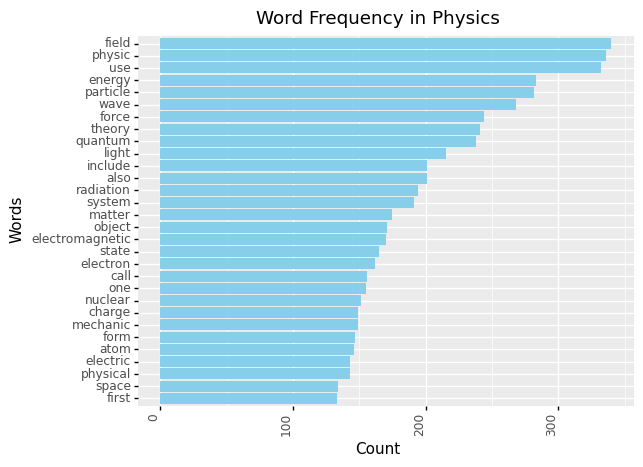

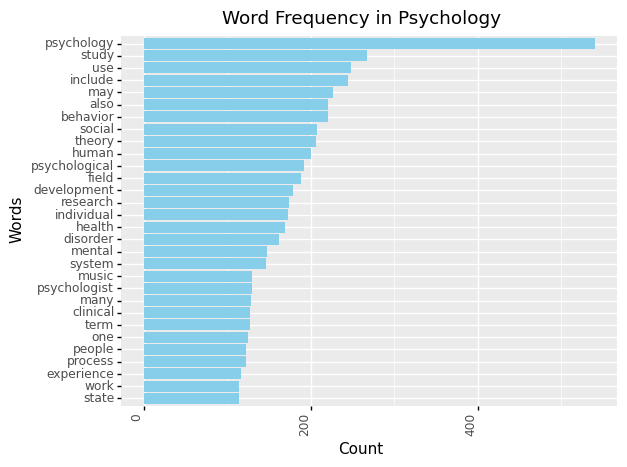

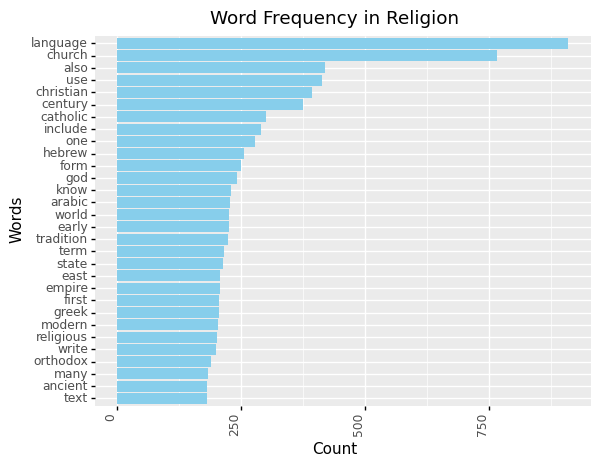

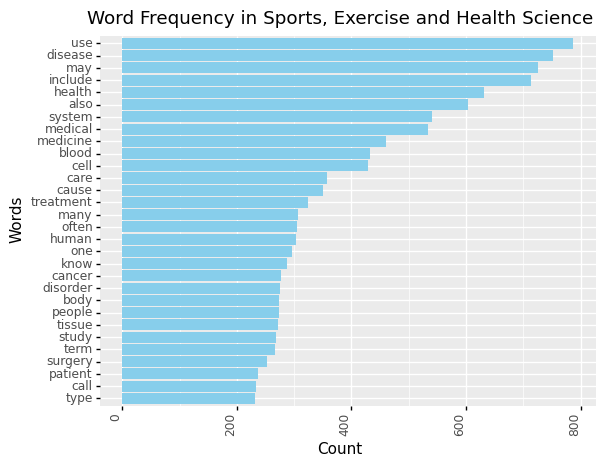

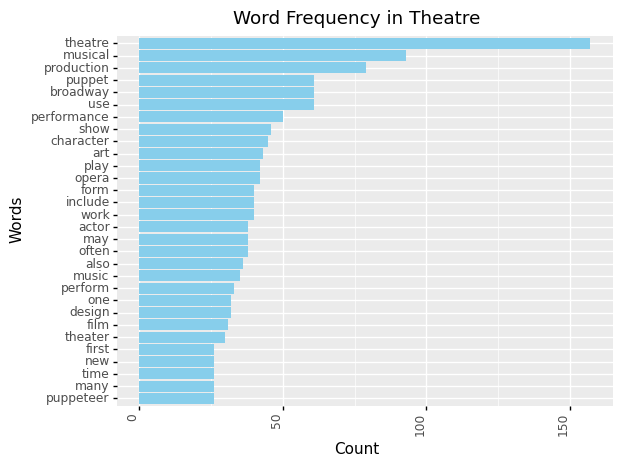

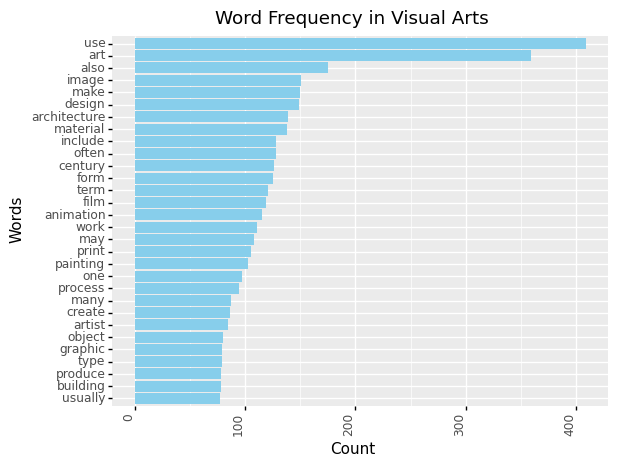

In [48]:
for tag in wkf_wf['tag'].unique():
    tdf = wkf_wf[wkf_wf['tag'] == tag].sort_values(by='count', ascending=False)
    g = ggplot(data=tdf) +\
            geom_bar(aes(x='word', y='count'), stat='identity', fill='skyblue') +\
            scale_x_discrete(limits=tdf['word'][::-1]) +\
            coord_flip() +\
            labs(title=f'Word Frequency in {tag}', x='Words', y='Count') +\
            theme(axis_text_x=element_text(rotation=90, hjust=1))

    print(g)

### 100mentors VS Wikipedia (top 30)

In [49]:
iwf = pd.DataFrame(columns=['index', 'perc'])
for cl in CLASSES:
    hm_words = set(hmf_wf[hmf_wf['tag'] == cl]['word'])
    wk_words = set(wkf_wf[wkf_wf['tag'] == cl]['word'])

    intersection = len(hm_words & wk_words)
    denominator = max(len(hm_words), len(wk_words))
    
    if denominator == 0:
        iwf = iwf.append({'index': cl, 'perc': 0}, ignore_index=True)
        continue

    iwf = iwf.append({'index': cl, 'perc': (intersection / denominator)*100}, ignore_index=True)

iwf.shape

(22, 2)

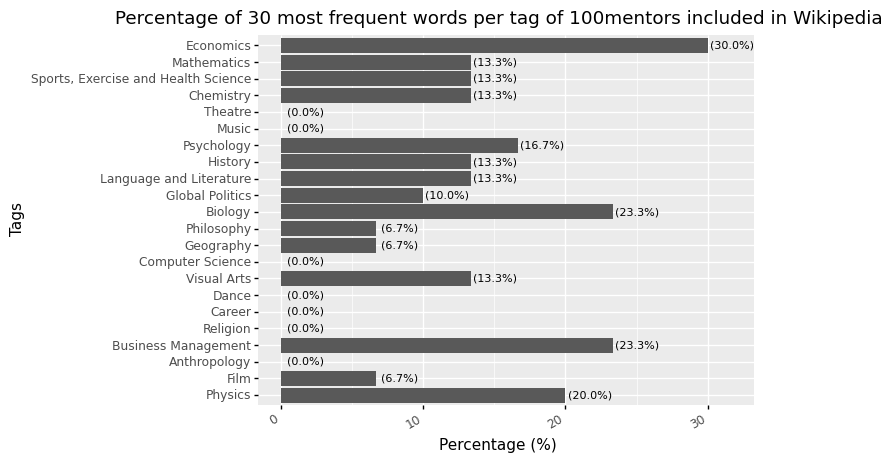

<ggplot: (367137012)>

In [50]:
ggplot(data=iwf) +\
    geom_bar(aes(x='index', y='perc'), stat='identity') +\
    geom_text(
        aes(x='index', y='perc', label='perc'),
        stat='identity',
        nudge_x=-0.25,
        nudge_y=1.7,
        va='bottom',
        color='black',
        size=8,
        format_string='({:.1f}%)'
    ) +\
    scale_x_discrete(limits=iwf['index'][::-1]) +\
    coord_flip() +\
    labs(title='Percentage of 30 most frequent words per tag of 100mentors included in Wikipedia', x='Tags', y='Percentage (%)') +\
    theme(axis_text_x=element_text(rotation=30, hjust=1))